In [ ]:
#!git clone https://gitlab.com/checkthat_lab/clef2021-checkthat-lab.git

In [ ]:
#%cd /content/clef2021-checkthat-lab/task1/data/subtask-1a--arabic/train

In [ ]:
#!unzip CT21-AR-Train-T1-v2.zip

In [ ]:
import logging
logging.basicConfig(level=logging.ERROR)

In [ ]:
!pip install pyarabic

In [ ]:
!pip install transformers==3

In [ ]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F


import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc


from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from tqdm import tqdm
import random
import os


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 23
np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.enabled = False 
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

In [ ]:
set_seed(66)

In [ ]:
data = pd.read_csv('/content/clef2021-checkthat-lab/task1/data/subtask-1a--arabic/train/CT21-AR-Train-T1-Labels.tsv',sep='\t',error_bad_lines=False)

In [ ]:
#data = df[df['claim']==1]

In [ ]:
#data.reset_index()

In [ ]:
#dev = pd.read_csv('/content/clef2021-checkthat-lab/task1/data/subtask-1a--arabic/train/CT21-AR-Dev-T1-Labels.tsv',sep='\t',error_bad_lines=False)
dev = pd.read_csv('/content/clef2021-checkthat-lab/task1/scorer/CT21-AR-Dev-T1-Labels.tsv',sep='\t',error_bad_lines=False)


In [ ]:
dev

,topic_id,tweet_id,tweet_url,tweet_text,claim,claim_worthiness
0,CT20-AR-02,1221223213583294470,https://twitter.com/user/status/12212232135832...,باقي هذا المجرم الجبار المتكبر وابنائه الجبابر...,1,0
1,CT20-AR-02,1221224671208755211,https://twitter.com/user/status/12212246712087...,الان عودة الاشتباكات العنيفه في نهم والجيش الو...,1,1
2,CT20-AR-02,1221226319243108353,https://twitter.com/user/status/12212263192431...,الوية العمالقة تعلن النفير العام للاستعداد لاق...,0,0
3,CT20-AR-02,1221243369348902912,https://twitter.com/user/status/12212433693489...,في الاسواق-اغاني جديده : الحوثيين راح يفبركون ...,1,0
4,CT20-AR-02,1221253458394779649,https://twitter.com/user/status/12212534583947...,#السعودية و #الإمارات من محرريين لليمن إلى احت...,1,0
...,...,...,...,...,...,...
656,CT20-AR-27,1233386563331121153,https://twitter.com/user/status/12333865633311...,الدكتور عبد الرزاق مقري: التيار العلماني المبي...,1,1
657,CT20-AR-27,1233403769016242176,https://twitter.com/user/status/12334037690162...,#الجمعة_54 حيا الله الأحرار.... جمعة قوية في م...,1,1
658,CT20-AR-27,1233404098751475712,https://twitter.com/user/status/12334040987514...,# 28 فبراير 2020. #الجمعة_54 من الحراك.. # الث...,0,0
659,CT20-AR-27,1233406731562225665,https://twitter.com/user/status/12334067315622...,شركة المراعي السعودية العالمية بمنتجات ذات جود...,1,1


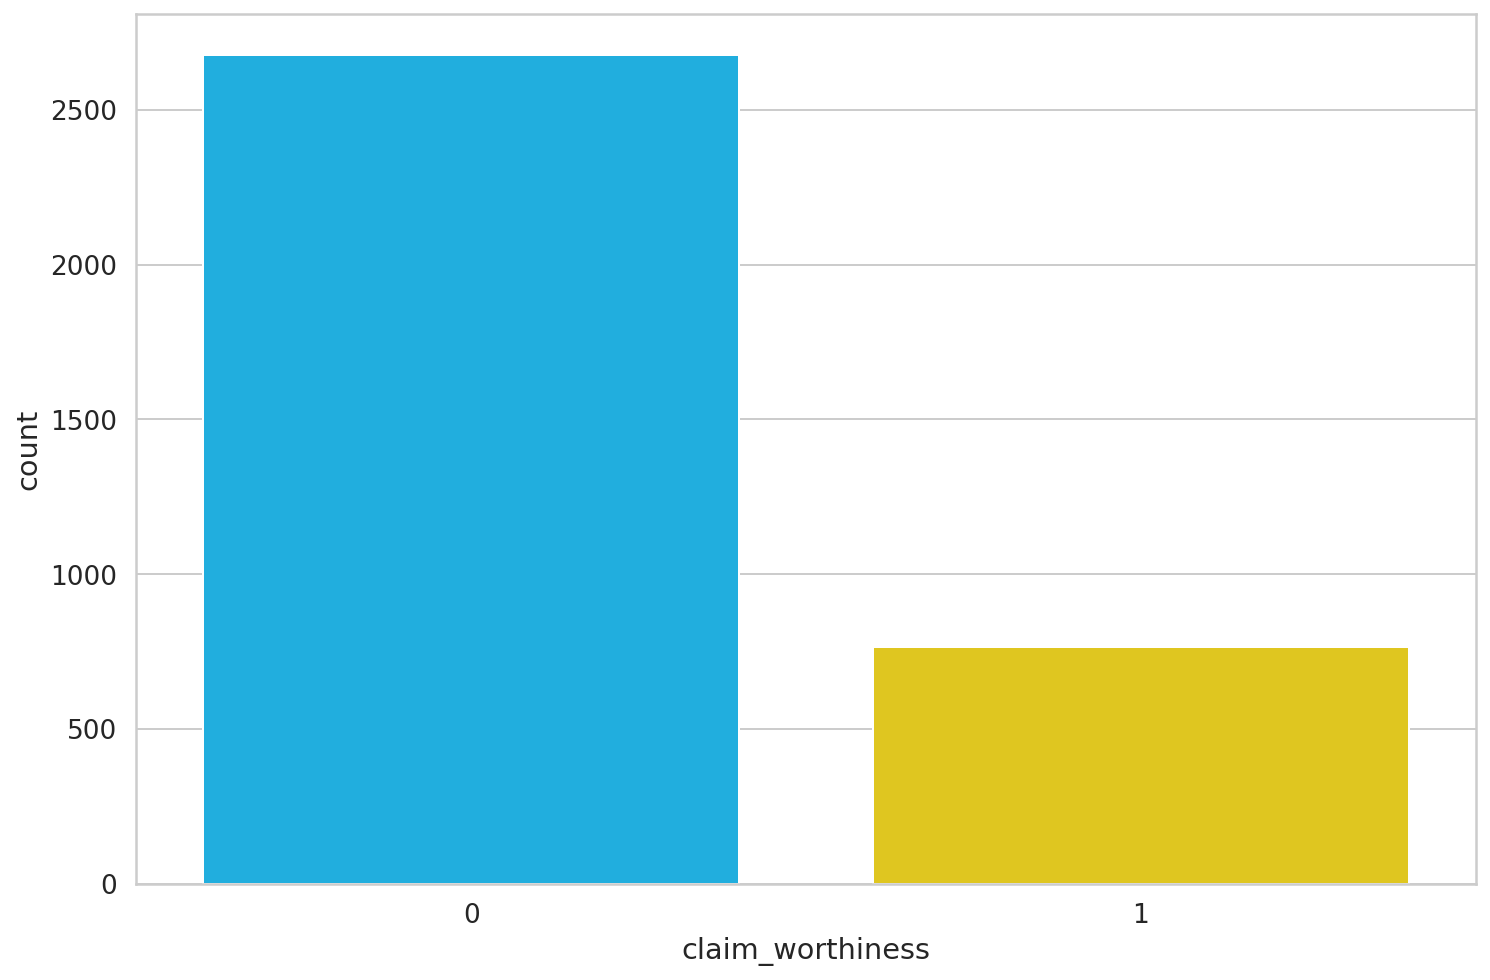

In [ ]:
sns.countplot(data=data,x="claim_worthiness")

In [ ]:
data.topic_id.unique()

array(['CT20-AR-01', 'CT20-AR-03', 'CT20-AR-08', 'CT20-AR-12',
       'CT20-AR-14', 'CT20-AR-23', 'CT20-AR-28_w1', 'CT20-AR-28_w2',
       'CT20-AR-29', 'CT20-AR-30'], dtype=object)

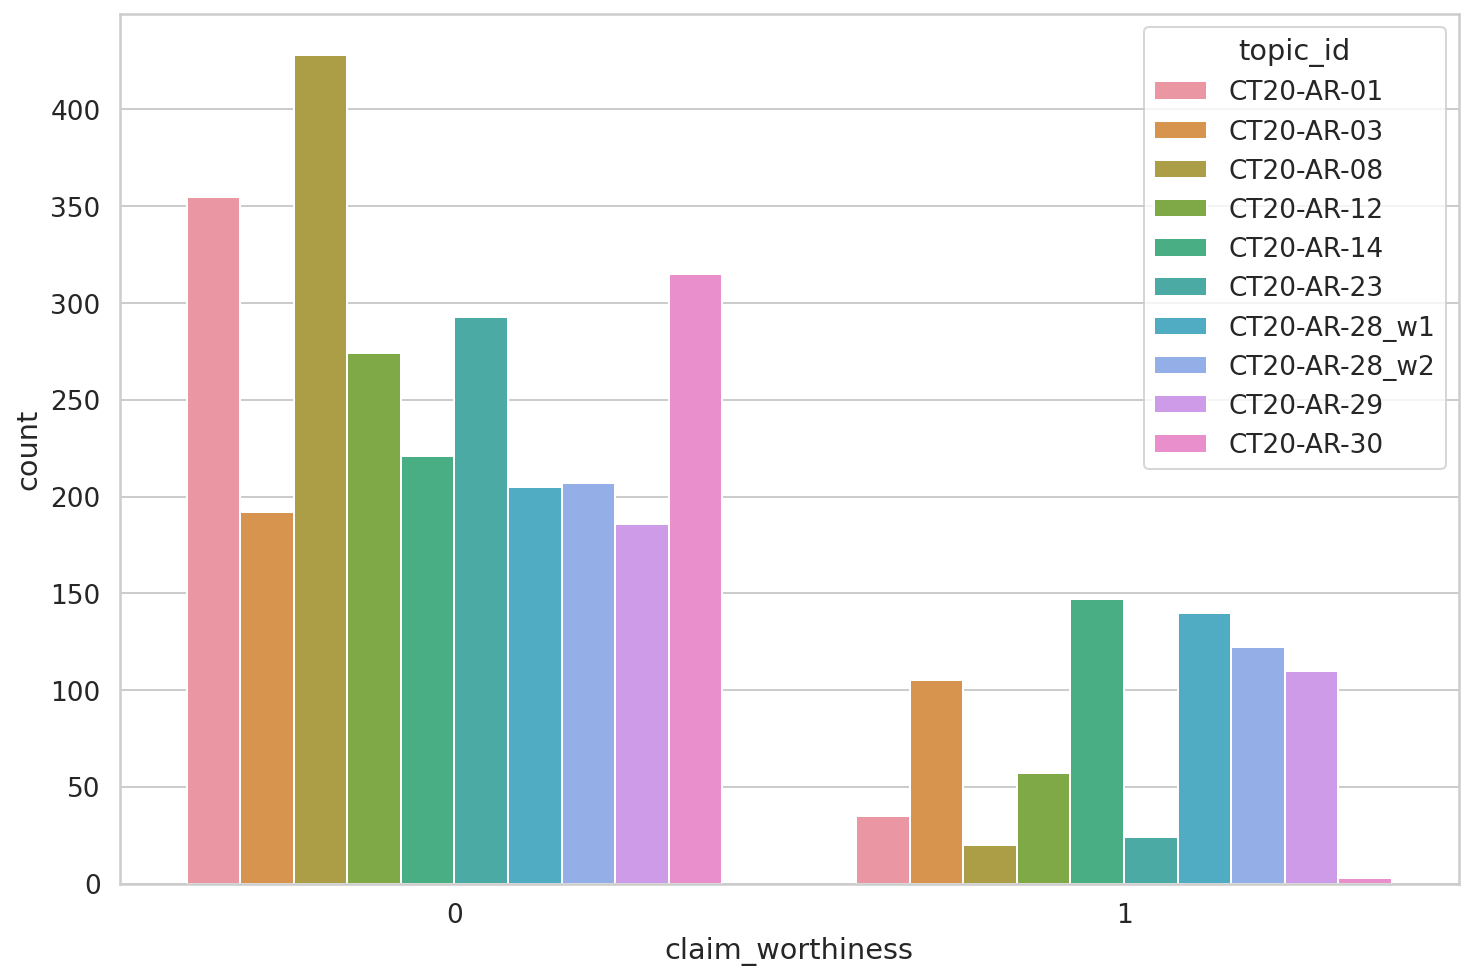

In [ ]:
sns.countplot(data=data,x="claim_worthiness",hue="topic_id")

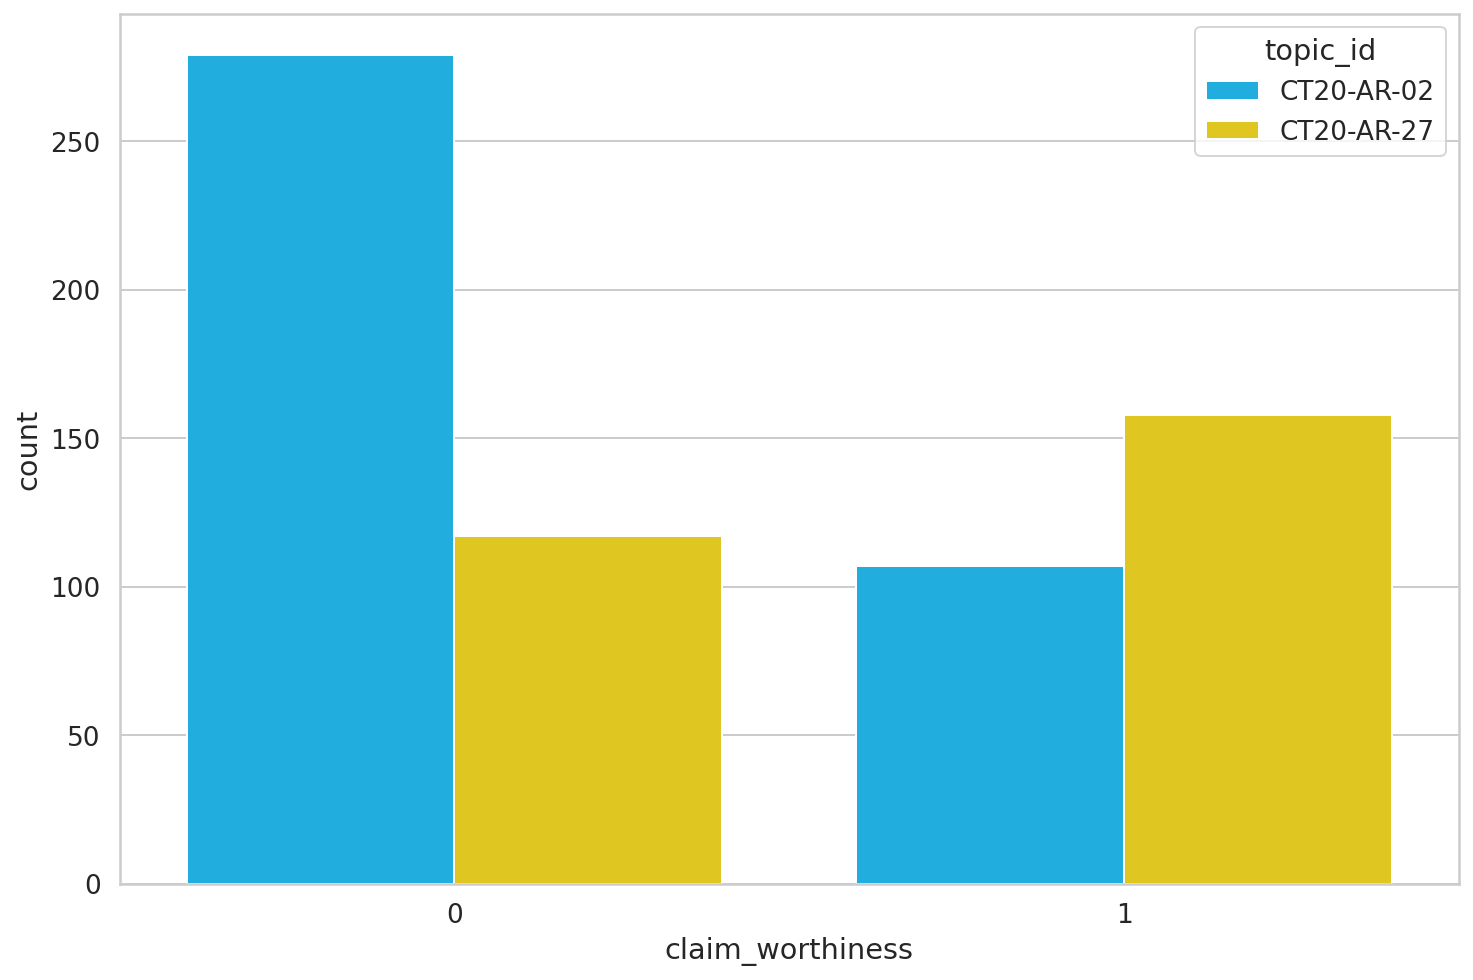

In [ ]:
sns.countplot(data=dev,x="claim_worthiness",hue="topic_id")

In [ ]:
data = data.sample(frac=1).reset_index(drop=True)

In [ ]:
import re
from os import listdir
from os.path import isfile, join
from pyarabic import araby

'''def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)
'''

def process(text):
    text = araby.strip_tashkeel(text) #delete *tashkil
    text = re.sub('\ـ+', ' ', text)  # delete letter madda

    '''text = re.sub('\ر+', 'ر', text)  # duplicate ra2
    text = re.sub('\اا+','ا',text)     #duplicate alif
    text = re.sub('\ووو+','و',text)    #duplicate waw (more than 3 times goes to 1
    text = re.sub('\ههه+','ههه',text)  #duplicate ha2 (more than 3 times goes to 1
    text = re.sub('\ةة+','ة',text)
    text = re.sub('\ييي+','ي',text)
    text = re.sub('أ','ا',text) # after to avoid mixing
    text = re.sub('آ','ا',text) # after to avoid mixing
    text = re.sub('إ','ا',text) # after to avoid mixing
    text = re.sub('ة','ه',text) # after ةة to avoid mixing ههه
    text = re.sub('ى','ي',text)'''
    text = re.sub("^https?:\/\/.*[\r\n]*", '', text, flags=re.MULTILINE)
    '''    text = deEmojify(text)'''
    #text = re.sub("^(@[A-Za-z0-9_]+)|([^0-9A-Za-z])"," ",text)

    text = " ".join(text.split()) #delete multispace
    return text
def remove_english(value):
    output = re.sub(r'\s*[A-Za-z0-9_]+\b', '' , value)
    results=re.sub(r'\W', ' ', output, flags=re.UNICODE)
    return results

In [ ]:
data["tweet_text"]=data["tweet_text"].apply(lambda x : remove_english(x))

In [ ]:
data["tweet_text"]=data["tweet_text"].apply(lambda x : process(x))
data["tweet_text"]=data["tweet_text"].apply(lambda x : remove_english(x))

In [ ]:
data.tweet_text

0       من تعليمات السلامة للوقاية من الكورونا الامتنا...
1       وزارة الصحة تخبر الرأي العام أنه تم ليلة الأحد...
2       ويهدد ويتوعد بهم كل خصومة ويرسل اشارت مشفرة لل...
3       اشفق على ع يد النسويات الي يحسب انه بيشبكهم لي...
4       كلنا_مسؤول البقاء في المنزل سلاحنا الأقوى بإذن...
                              ...                        
3434    انا سوداني وفعل برهان يمثلني ولو كنت محلو كان ...
3435    شعور جدودنا وأهالينا في أيام مثل معاهدة وادي ع...
3436    عاجل الصحه_العالمية لا توجد إصابات بين المصريي...
3437    بموضوع قضية إن الراهبات بشر والبشر ي خط ئون وي...
3438    النسويات الحقيقيات لازم يعادون هالعي نات اكثر ...
Name: tweet_text, Length: 3439, dtype: object

In [ ]:
dev["tweet_text"]=dev["tweet_text"].apply(lambda x : process(x))
dev["tweet_text"]=dev["tweet_text"].apply(lambda x : remove_english(x))

In [ ]:
data

,topic_id,tweet_id,tweet_url,tweet_text,claim,claim_worthiness
0,CT20-AR-28_w1,1240397510809706496,https://twitter.com/user/status/12403975108097...,من تعليمات السلامة للوقاية من الكورونا الامتنا...,0,0
1,CT20-AR-28_w1,1239666059357179904,https://twitter.com/user/status/12396660593571...,وزارة الصحة تخبر الرأي العام أنه تم ليلة الأحد...,1,1
2,CT20-AR-14,1225766485097926656,https://twitter.com/user/status/12257664850979...,ويهدد ويتوعد بهم كل خصومة ويرسل اشارت مشفرة لل...,0,0
3,CT20-AR-08,1222606721409015808,https://twitter.com/user/status/12226067214090...,اشفق على ع يد النسويات الي يحسب انه بيشبكهم لي...,0,0
4,CT20-AR-28_w2,1242523522876006401,https://twitter.com/user/status/12425235228760...,كلنا_مسؤول البقاء في المنزل سلاحنا الأقوى بإذن...,0,0
...,...,...,...,...,...,...
3434,CT20-AR-12,1224867179222446080,https://twitter.com/user/status/12248671792224...,انا سوداني وفعل برهان يمثلني ولو كنت محلو كان ...,0,0
3435,CT20-AR-01,1222216404654608385,https://twitter.com/user/status/12222164046546...,شعور جدودنا وأهالينا في أيام مثل معاهدة وادي ع...,0,0
3436,CT20-AR-03,1223925105417445376,https://twitter.com/user/status/12239251054174...,عاجل الصحه_العالمية لا توجد إصابات بين المصريي...,1,1
3437,CT20-AR-08,1222644996521807881,https://twitter.com/user/status/12226449965218...,بموضوع قضية إن الراهبات بشر والبشر ي خط ئون وي...,1,0


In [ ]:
%cd /content/

/content


In [ ]:
dev[dev['claim']==0]['tweet_id']

2      1221226319243108353
5      1221257562810671109
6      1221262994732089344
9      1221311538126082048
10     1221312832362438656
              ...         
645    1233132895000309774
650    1233162454936555520
651    1233290442462179329
653    1233369847830061056
658    1233404098751475712
Name: tweet_id, Length: 278, dtype: int64

In [ ]:
sub=dev.copy()
sub.drop(["tweet_url","tweet_text","claim_worthiness"],1,inplace=True)

In [ ]:
data.drop(["topic_id","tweet_url","tweet_id","claim"],axis=1,inplace=True)

In [ ]:
dev.drop(["topic_id","tweet_url","tweet_id","claim"],axis=1,inplace=True)

In [ ]:
data

,tweet_text,claim_worthiness
0,من تعليمات السلامة للوقاية من الكورونا الامتنا...,0
1,وزارة الصحة تخبر الرأي العام أنه تم ليلة الأحد...,1
2,ويهدد ويتوعد بهم كل خصومة ويرسل اشارت مشفرة لل...,0
3,اشفق على ع يد النسويات الي يحسب انه بيشبكهم لي...,0
4,كلنا_مسؤول البقاء في المنزل سلاحنا الأقوى بإذن...,0
...,...,...
3434,انا سوداني وفعل برهان يمثلني ولو كنت محلو كان ...,0
3435,شعور جدودنا وأهالينا في أيام مثل معاهدة وادي ع...,0
3436,عاجل الصحه_العالمية لا توجد إصابات بين المصريي...,1
3437,بموضوع قضية إن الراهبات بشر والبشر ي خط ئون وي...,0


In [ ]:
train, val = train_test_split(data, test_size=0.15,random_state=23)

In [ ]:
train

,tweet_text,claim_worthiness
769,يقيمون ندوات وتجمعات بشرية لشرح مضار التجمعات ...,0
805,فيديو برنامج مصري يتصل على كورونا كورونا_مصر,0
2292,الدروس الأخلاقية من قصة يوسف في القرآن إلقاء ا...,0
2505,عاجل توقف الرحلات في مطار معيتيقة بالعاصمة الل...,1
2651,استقر اليهود في فلسطين وعاثوا في الأرض فسادا ف...,0
...,...,...
2998,طبع ا الآن الذباب القط ري يجيك يقول مزورة ال و...,0
1993,مرزوق ترى البدون اللي يشتغل عند أخوك واللي بس ...,0
1064,مرتزقه وكل نبحه لها مبلغ وقدره مقصرين شدوا حيل...,0
742,لو نحن دولة محترمة جد ماكان وقعنا شيك على بياض...,0


In [ ]:
train.reset_index(drop=True, inplace=True)
val.reset_index(drop=True, inplace=True)

###Tokenisation

In [ ]:
PRE_TRAINED_MODEL_NAME = 'aubmindlab/bert-base-arabertv01'

In [ ]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [ ]:
train.tweet_text[1]

'فيديو برنامج مصري يتصل على كورونا كورونا_مصر'

In [ ]:
sample_txt = train.tweet_text[1]

tokens = tokenizer.tokenize(sample_txt)

token_ids = tokenizer.convert_tokens_to_ids(tokens)

print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: فيديو برنامج مصري يتصل على كورونا كورونا_مصر
   Tokens: ['فيديو', 'برنامج', 'مصري', 'يتصل', 'على', 'كورونا', 'كورونا', '[UNK]', 'مصر']
Token IDs: [23583, 35652, 11402, 13363, 2881, 37385, 37385, 60122, 3534]


In [ ]:
len(tokens)

9

In [ ]:
tokenizer.special_tokens_map

{'cls_token': '[CLS]',
 'mask_token': '[MASK]',
 'pad_token': '[PAD]',
 'sep_token': '[SEP]',
 'unk_token': '[UNK]'}

In [ ]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=120,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)


encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'فيديو',
 'برنامج',
 'مصري',
 'يتصل',
 'على',
 'كورونا',
 'كورونا',
 '[UNK]',
 'مصر',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[

In [ ]:
class Tokenisation(Dataset):
    
    
    def __init__(self, data, targets, tokenizer, max_len):
        self.data = data
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.pad_vid = self.tokenizer.vocab["[PAD]"]
        
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, item):
        data = str(self.data[item])
        data = " ".join(data.split())
        target = self.targets
        
        encoding = self.tokenizer.encode_plus(
          data,
          add_special_tokens=True,
          max_length=self.max_len,
          return_token_type_ids=False,
          pad_to_max_length=True,
          return_attention_mask=True,
          return_tensors='pt',
        )
        
        ids = encoding['input_ids']
        masks = encoding['attention_mask']
        token_type_ids = encoding['input_ids']
        
        true_seq_length = len(encoding['input_ids'][0])
        pad_size = self.max_len - true_seq_length
        pad_ids = torch.Tensor([self.pad_vid] * pad_size).long()
        ids = torch.cat((encoding['input_ids'][0], pad_ids))
        
        
        #padding_len = self.max_len - len(ids)
        #ids = ids + ([0] * padding_len)
        #masks = ids + ([0] * padding_len)
        #token_type_ids = token_type_ids + ([0] * padding_len)
        
        return {
          'text': data,
          'input_ids': ids.flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target[item], dtype=torch.long)
        }

In [ ]:
def dataLoader(df, tokenizer, max_len, batch_size):
    ds = Tokenisation(
    data=df['text'].to_numpy(),
    targets=df['label'].to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
    )
    return DataLoader(ds,batch_size=batch_size, num_workers=4)

In [ ]:
train.rename(columns={'tweet_text': 'text'}, inplace=True)
train.rename(columns={'claim_worthiness': 'label'}, inplace=True)
val.rename(columns={'tweet_text': 'text'}, inplace=True)
val.rename(columns={'claim_worthiness': 'label'}, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [ ]:
BATCH_SIZE = 32
MAX_LEN = 150

train_data_loader = dataLoader(train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = dataLoader(val, tokenizer, MAX_LEN, BATCH_SIZE)
#test_data_loader = dataLoader(test, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


dict_keys(['text', 'input_ids', 'attention_mask', 'targets'])

In [ ]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([32, 150])
torch.Size([32, 150])
torch.Size([32])


###Building the model


In [ ]:
class TextClassifier(nn.Module):
    
    def __init__(self, n_classes):
        super(TextClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        

            
    
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        #print(pooled_output)
        output = self.drop(pooled_output)
        return self.out(output)
    
    def unfreeze(self,start_layer,end_layer):
        def children(m):
            return m if isinstance(m, (list, tuple)) else list(m.children())
        def set_trainable_attr(m, b):
            m.trainable = b
            for p in m.parameters():
                p.requires_grad = b
        def apply_leaf(m, f):
            c = children(m)
            if isinstance(m, nn.Module):
                f(m)
            if len(c) > 0:
                for l in c:
                    apply_leaf(l, f)
        def set_trainable(l, b):
            apply_leaf(l, lambda m: set_trainable_attr(m, b))

        # You can unfreeze the last layer of bert by calling set_trainable(model.bert.encoder.layer[23], True)
        set_trainable(self.bert, False)
        for i in range(start_layer, end_layer+1):
            set_trainable(self.bert.encoder.layer[i], True)


In [ ]:
len(train.label.unique())

2

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
model = TextClassifier(len(train.label.unique()))
model = model.to(device)

In [ ]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([32, 150])
torch.Size([32, 150])


In [ ]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.5117, 0.4883],
        [0.4922, 0.5078],
        [0.5379, 0.4621],
        [0.5775, 0.4225],
        [0.2966, 0.7034],
        [0.3102, 0.6898],
        [0.5515, 0.4485],
        [0.5315, 0.4685],
        [0.4512, 0.5488],
        [0.5478, 0.4522],
        [0.5461, 0.4539],
        [0.6481, 0.3519],
        [0.4617, 0.5383],
        [0.3471, 0.6529],
        [0.5590, 0.4410],
        [0.3720, 0.6280],
        [0.5162, 0.4838],
        [0.3963, 0.6037],
        [0.4016, 0.5984],
        [0.5397, 0.4603],
        [0.5365, 0.4635],
        [0.4945, 0.5055],
        [0.4066, 0.5934],
        [0.3533, 0.6467],
        [0.3966, 0.6034],
        [0.5256, 0.4744],
        [0.4845, 0.5155],
        [0.5053, 0.4947],
        [0.4958, 0.5042],
        [0.5184, 0.4816],
        [0.4747, 0.5253],
        [0.4389, 0.5611]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
from sklearn.metrics import average_precision_score
import utils

In [ ]:
EPOCHS = 6
MAX_LENGTH = 128
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 16

LearningRate = 1e-6

BETAS = (0.9, 0.999)
BERT_WEIGHT_DECAY = 0.01
EPS = 1e-8

# Define identifiers & group model parameters accordingly 
bert_identifiers = ['embedding', 'encoder', 'pooler']
no_weight_decay_identifiers = ['bias', 'LayerNorm.weight']
grouped_model_parameters = [
        {'params': [param for name, param in model.named_parameters()
                    if any(identifier in name for identifier in bert_identifiers) and
                    not any(identifier_ in name for identifier_ in no_weight_decay_identifiers)],
        'lr': LearningRate,
        'betas': BETAS,
        'weight_decay': BERT_WEIGHT_DECAY,
        'eps': EPS},
        {'params': [param for name, param in model.named_parameters()
                    if any(identifier in name for identifier in bert_identifiers) and
                    any(identifier_ in name for identifier_ in no_weight_decay_identifiers)],
        'lr': LearningRate,
        'betas': BETAS,
        'weight_decay': 0.0,
        'eps': EPS},
        {'params': [param for name, param in model.named_parameters()
                    if not any(identifier in name for identifier in bert_identifiers)],
        'lr': LearningRate,
        'betas': BETAS,
        'weight_decay': 0.0,
        'eps': EPS}
]

# Define optimizer
optimizers = AdamW(grouped_model_parameters)

optimizer = AdamW(model.parameters(), lr=LearningRate , correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

es = utils.EarlyStopping(patience=3, mode="min")

loss_fn = nn.BCELoss().to(device)

In [ ]:
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    
    
    model = model.train()
    losses = []
    averagreP = []
    correct_predictions = 0
    for d in tqdm(data_loader):
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        preds = F.softmax(preds,dim=1)
        targets = targets.type_as(preds)
        preds = preds[:, 1]
        loss = loss_fn(preds, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        AP = average_precision_score(targets.cpu().detach().numpy(),preds.cpu().detach().numpy())
        averagreP.append(AP)
       
    return np.mean(averagreP),np.mean(losses)

In [ ]:
import math

In [ ]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    
    model = model.eval()
    
    losses = []
    averagreP = []
    
    correct_predictions = 0
    
    with torch.no_grad():
        for d in tqdm(data_loader):
            input_ids = d["input_ids"].to(device)
            #print("input IDS" + str(input_ids))
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            #print('Targets' + str(targets))
            
            preds = model(
            input_ids=input_ids,
            attention_mask=attention_mask
            )

            preds = F.softmax(preds, dim=1)
            targets = targets.type_as(preds)
            preds = preds[:, 1]
            #print("Preds : "+str(preds))

            loss = loss_fn(preds, targets)
            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())
            AP = average_precision_score(targets.cpu().detach().numpy(),preds.cpu().detach().numpy())
            if (math.isnan(AP)):
              AP = average_precision_score(targets.cpu().detach().numpy().reshape((-1)),preds.cpu().detach().numpy().reshape((-1)))
              print('AP is nan')
            averagreP.append(AP)
       
    return np.mean(averagreP),np.mean(losses)


In [ ]:
history = defaultdict(list)
best_ap = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_ap,train_loss = train_epoch(
                                        model,
                                        train_data_loader,
                                        loss_fn,
                                        optimizer,
                                        device,
                                        scheduler,
                                        len(train),

    )
    print(f'Train loss {train_loss} Aver Precision {train_ap}')
    val_ap, val_loss = eval_model(
                                    model,
                                    val_data_loader,
                                    loss_fn,
                                    device,
                                    len(val)
    )
    print(f'Val   loss {val_loss} Aver Precision {val_ap}')
    print()
    torch.save(model.state_dict(), 'model_state.bin')
    es(val_loss, model, model_path=f"model_state.bin")
    if es.early_stop:
        print("Early stopping")
        break
    history['train_ap'].append(train_ap)
    history['train_loss'].append(train_loss)
    history['val_ap'].append(val_ap)
    history['val_loss'].append(val_loss)
    
    '''if val_ap > best_ap:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_ap = val_ap'''

  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 1/6
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
  0%|          | 0/17 [00:00<?, ?it/s]

Train loss 0.3990604379416808 Aver Precision 0.6875692085396946


100%|██████████| 17/17 [00:04<00:00,  3.73it/s]


Val   loss 0.27825022707967195 Aver Precision 0.8277863851330245

Validation score improved (inf --> 0.27825022707967195). Saving model!


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 2/6
----------


  0%|          | 0/17 [00:00<?, ?it/s]

Train loss 0.2670902447451068 Aver Precision 0.8471155417916496


100%|██████████| 17/17 [00:04<00:00,  3.65it/s]


Val   loss 0.25525369451326485 Aver Precision 0.8458462773372362

Validation score improved (0.27825022707967195 --> 0.25525369451326485). Saving model!


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 3/6
----------


  0%|          | 0/17 [00:00<?, ?it/s]

Train loss 0.24289852826167707 Aver Precision 0.8645270707864602


100%|██████████| 17/17 [00:04<00:00,  3.57it/s]


Val   loss 0.2470335018108873 Aver Precision 0.8596700556830733

Validation score improved (0.25525369451326485 --> 0.2470335018108873). Saving model!


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 4/6
----------


  0%|          | 0/17 [00:00<?, ?it/s]

Train loss 0.22521985634027616 Aver Precision 0.873012135630606


100%|██████████| 17/17 [00:04<00:00,  3.56it/s]


Val   loss 0.24325952525524533 Aver Precision 0.8652663384852386

Validation score improved (0.2470335018108873 --> 0.24325952525524533). Saving model!


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 5/6
----------


  0%|          | 0/17 [00:00<?, ?it/s]

Train loss 0.21423227048438528 Aver Precision 0.8992961721823995


100%|██████████| 17/17 [00:04<00:00,  3.52it/s]


Val   loss 0.2421452359241598 Aver Precision 0.8614848258801964

Validation score improved (0.24325952525524533 --> 0.2421452359241598). Saving model!


  0%|          | 0/92 [00:00<?, ?it/s]

Epoch 6/6
----------


  0%|          | 0/17 [00:00<?, ?it/s]

Train loss 0.2102547674237386 Aver Precision 0.9003549820931461


100%|██████████| 17/17 [00:04<00:00,  3.54it/s]


Val   loss 0.24196027526084116 Aver Precision 0.8550189061789827

EarlyStopping counter: 1 out of 3


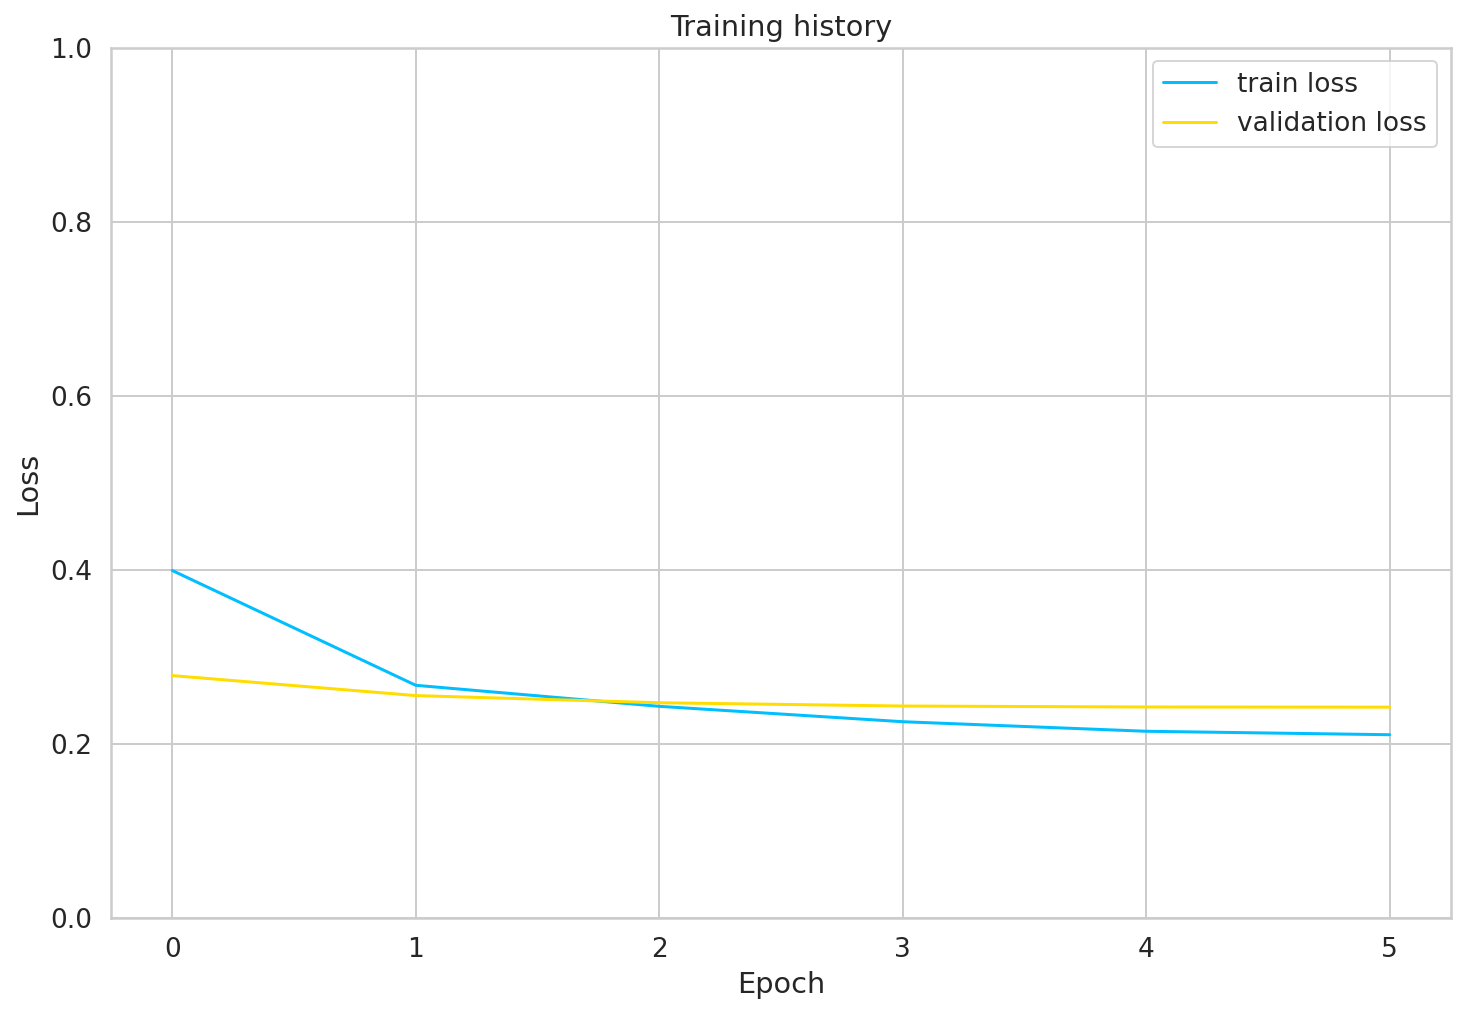

In [ ]:
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')
plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);



##Evaluation

In [ ]:
def get_predictions(model, data_loader):
    model = model.eval()
    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []
    with torch.no_grad():
      for d in data_loader:
          input_ids = d["input_ids"].to(device)
          attention_mask = d["attention_mask"].to(device)
          targets = d["targets"].to(device)
          preds = model(
          input_ids=input_ids,
          attention_mask=attention_mask
          )
          preds = F.softmax(preds, dim=1)
          #review_texts.extend(texts)
          #predictions.extend(preds)
          prediction_probs.extend(preds)
          real_values.extend(targets)
    #predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()
    return prediction_probs, real_values

In [ ]:
dev.head()

,tweet_text,claim_worthiness
0,باقي هذا المجرم الجبار المتكبر وابنائه الجبابر...,0
1,الان عودة الاشتباكات العنيفه في نهم والجيش الو...,1
2,الوية العمالقة تعلن النفير العام للاستعداد لاق...,0
3,في الاسواق اغاني جديده الحوثيين راح يفبركون ...,0
4,السعودية و الإمارات من محرريين لليمن إلى احت...,0


In [ ]:
dev.rename(columns={'tweet_text': 'text'}, inplace=True)
dev.rename(columns={'claim_worthiness': 'label'}, inplace=True)

In [ ]:
test_data_loader = dataLoader(dev, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
test_ap, test_loss= eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(dev)
)

  0%|          | 0/21 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
100%|██████████| 21/21 [00:06<00:00,  3.44it/s]


In [ ]:
test_ap

0.8552362847480699

In [ ]:
y_pred_prob,y_true = get_predictions(model,test_data_loader)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
y_pred_prob

tensor([[0.9880, 0.0120],
        [0.1904, 0.8096],
        [0.5100, 0.4900],
        ...,
        [0.9757, 0.0243],
        [0.5559, 0.4441],
        [0.9683, 0.0317]])

In [ ]:
#y_pred = y_pred_prob[:,0]-y_pred_prob[:,1]

In [ ]:
sub["score"]=y_pred_prob[:,1]
#sub.loc[sub['claim'] == 0, 'score'] = 0

In [ ]:
sub['runID']="Model_0.86"
sub.drop(['claim'],1,inplace=True)

In [ ]:
max(sub['score'])

0.9366483688354492

In [ ]:
'''i=0
for i in range(len(sub['score'])):
  if (sub['score'][i]>0.001 and sub['score'][i]<0.004):
    sub['score'][i] = 0
  if (sub['score'][i]>0.97):
      sub['score'][i] = 1'''

In [ ]:
sub

,topic_id,tweet_id,score,runID
0,CT20-AR-02,1221223213583294470,0.011963,Model_0.86
1,CT20-AR-02,1221224671208755211,0.809649,Model_0.86
2,CT20-AR-02,1221226319243108353,0.489994,Model_0.86
3,CT20-AR-02,1221243369348902912,0.233985,Model_0.86
4,CT20-AR-02,1221253458394779649,0.033274,Model_0.86
...,...,...,...,...
656,CT20-AR-27,1233386563331121153,0.113019,Model_0.86
657,CT20-AR-27,1233403769016242176,0.026276,Model_0.86
658,CT20-AR-27,1233404098751475712,0.024331,Model_0.86
659,CT20-AR-27,1233406731562225665,0.444113,Model_0.86


In [ ]:
%cd /content/clef2021-checkthat-lab/task1/scorer

/content/clef2021-checkthat-lab/task1/scorer


In [ ]:
sub.to_csv('sub.tsv',sep='\t',index=False,header=None)

In [ ]:
'''path="/content/clef2021-checkthat-lab/task1/scorer/new_test.csv"

import csv
reader = list(csv.reader(open(path, "rU"), delimiter=','))
writer = csv.writer(open(path, 'w'), delimiter='\t')
writer.writerows(row for row in reader)'''

In [ ]:
!python3 subtask_1a.py --gold-file-path=CT21-AR-Dev-T1-Labels.tsv --pred-file-path=sub.tsv

INFO : Started evaluating results for subtask-1a ...
INFO : Reading gold predictions from file CT21-AR-Dev-T1-Labels.tsv
INFO : Reading predicted ranking order from file sub.tsv
INFO : ================================================= RESULTS for sub.tsv ==================================================
INFO : AVERAGE PRECISION:            0.8504    
INFO : ========================================================================================================================
INFO : RECIPROCAL RANK:              1.0000    
INFO : ========================================================================================================================
INFO : R-PRECISION (R=265):          0.7547    
INFO : ========================================================================================================================
INFO : PRECISION@N:                  @1        @3        @5        @10       @20       @50       
INFO :                               1.0000    1.0000    1.0000    0

##Evaluation on testset


In [ ]:
%cd /content/clef2021-checkthat-lab/task1/test-input

In [ ]:
!unzip subtask-1a--arabic.zip

In [ ]:
test = pd.read_csv('/content/clef2021-checkthat-lab/task1/test-input/CT21-AR-Test-T1.tsv',sep='\t',error_bad_lines=False)

In [ ]:
test

In [ ]:
test.drop(['topic_id','tweet_id','tweet_url'],axis = 1,inplace=True)

In [ ]:
test["tweet_text"]=test["tweet_text"].apply(lambda x : process(x))
test["tweet_text"]=test["tweet_text"].apply(lambda x : remove_english(x))

In [ ]:
test

In [ ]:
submission = test.copy()

In [ ]:
submission.drop(['tweet_url','tweet_text'],axis=1,inplace=True)

In [ ]:
test['label'] = 0

In [ ]:
test.rename(columns={'tweet_text': 'text'}, inplace=True)

In [ ]:
testset_data_loader = dataLoader(test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
y_pred,y_true_ = get_predictions(model,testset_data_loader)

In [ ]:
submission['score'] = y_pred[:,1]
submission['runID']="Model_1"

In [ ]:
submission.to_csv('submission.tsv',sep='\t',index=False,header=None)

In [ ]:
       
       #epoch badeleteha 5 
#batch_size = 32 , maxlength = 128 , lr=2e-5
#early stopping epoch 10